# Data Science with Neo4j Using Yelp Data

### Course Overview

This 4-part series covers data science concepts and techniques applicable to various domains and industries. Through practical examples, we will show just how easy it is to derive insights given a particular dataset. Thanks to Yelp, we have access to business, review and user data across multiple cities.  Using Neo4j to model and store our highly connected data, we will make sense of it, using a combination of Cypher, graph-specific algorithms and standard Python machine learning libraries.  Below are the topics that we will cover in this course:

1.  Exploratory Data Analysis
2.  Segmentation and Community Detection
3.  Similarity and Recommendations
4.  Influencers and Centrality

### Pre-requisites

This course assumes that you have basic knowledge of the Cypher query language and some scripting in Python. For those not yet familiar with Cypher but have some experience with SQL, you will quickly discover that Cypher is just SQL for graphs! To help you get started, or simply brush up, please click [here](https://neo4j.com/docs/cypher-refcard/current/).  

We will use Python to demonstrate traditional, non-graph specific data science techniques and algorithms.  While other languages have equally rich data manipulation and machine learning libraries, we have chosen Python for this course for its relatively low learning curve.  It is also a general purpose language, as opposed to statistics-focused, and has great emphasis on code readability. For Python resources, please click [here](https://www.python.org/doc/).
 
One of the key concepts in the field of data science is the idea of reproducibility.  This means that we want our analysis to be performed so that it is well-documented and can easily be re-executed if needed.  For this, we use Jupyter Notebook which allows us to combine Python code, output, visualization and text all in one place!  To learn more about the notebook, please click [here](http://jupyter.org).

The data required for this course has been pre-loaded into Neo4j. However, if you are interested in getting hands-on experience in creating your own Neo4j database, please follow instructions [here](https://github.com/neo4j-contrib/neo4j-data-science-yelp/blob/master/notebooks/neo4j_yelp_00_data_load.ipynb).

### Module 1: Exploratory Data Analysis

The first thing we need to do when given a dataset is explore it. This allows us to understand the population that we are working with, as well as the quality of the data at hand.  Simple descriptive statistics like counts, averages and percentages help us gain insight into the various dimensions present in the data. In addition, visualizing distributions is useful in discerning values that are considered normal from those deemed to be extreme. In statistics, extreme values are commonly referred to as "outliers".

In the data science pipeline, it is at the exploratory stage that we often discover that data is hardly ever clean or perfect. This means that we will come across dimensions or variables that either have missing, incorrect or extreme values.  Although it is beyond the scope of this course, it is worth noting that as data scientists, we learn to make adjustments and be creative in order to make the data more feasible to work with.  Examples of common techniques include applying transformation functions to variables, imputing missing values and deriving new variables from existing ones.

In this module, we will focus solely on data exploration. Data cleansing techniques is not within the scope of this course.

### Understanding the Toronto Food Scene

Our goal is to understand the food scene in one of the most diverse cities in the world: Toronto!  At the time of writing, [Statistics Canada](http://www12.statcan.gc.ca/census-recensement/2016/dp-pd/prof/details/page.cfm?Lang=E&Geo1=CSD&Code1=3520005&Geo2=PR&Code2=01&Data=Count&SearchText=toronto&SearchType=Begins&SearchPR=01&B1=All) estimates that Toronto is home to 2.7 million people, nearly half of whom were born outside of Canada (approximately 1.3 million).  Known for being a multi-cultural city, what can we discover about its food culture?  In this module, we will demonstrate how to perform exploratory data analysis using a subset of the Yelp dataset.  While there are other cities and businesses present in the data, we will focus our analysis on restaurants located in Toronto.

Here's the graph data model that we are working with:[insert data model here]


We have `Users` who <i>wrote</i> `Reviews`, and these `Reviews` are <i>review of</i> `Businesses`.  A `Business` is <i>in</i> a `Category` and it is located <i>in</i> a `City`, which in turn is <i>in</i> a `State`.  Note also that `Users` can be <i>friends with</i> other `Users`.  

We begin this section by computing high-level metrics associated with our population of interest. Through Cypher queries, we will discover insights related to Toronto restaurants: the proportion of the city's overall service industry that they account for, their distribution by neighborhood, as well as their quality as inferred by user ratings.

First, let's understand the size of the service industry in Toronto and the proportion that restaurants account for.

#### Query 1: How many businesses are there in Toronto?

In [1]:
from neo4j.v1 import GraphDatabase, basic_auth
import pandas as pd
import matplotlib.pyplot as plt

In [41]:
driver = GraphDatabase.driver("bolt://localhost:7687", auth=basic_auth("neo4j", "neo4jneo4j"))

In [204]:
query1 = """
         MATCH (b:Business)-[:IN_CITY]->(c:City {name:'Toronto'})
         RETURN COUNT(b) AS num_businesses
         """

with driver.session() as session:
    result1 = session.run(query1)

for record in result1:
    business_count = record['num_businesses']
    
print('Number of businesses in Toronto: {0}\n'.format(business_count))

Number of businesses in Toronto: 17206



In the Cypher query above, we take note of two things: first, the use of the `name` property in the `City` node to select only businesses in Toronto.   Second, the use of the aggregate function COUNT(`<expression>`). Those familiar with SQL know that there exists a function with the same name.  Similar to its SQL counterpart, Cypher returns the number of non-null values for the given `expression`.  

#### Query 2: What percentage of businesses in Toronto are restaurants?

In [214]:
query2 = """
         MATCH (b:Business)-[:IN_CITY]->(c:City {name:'Toronto'}),
               (b)-[:IN_CATEGORY]->(cat:Category {name:'Restaurants'})
         RETURN COUNT(b) AS num_restaurants
         """

with driver.session() as session:
    result2 = session.run(query2)

for record in result2:
    restaurant_count = record['num_restaurants']
    
print('Number of restaurants in Toronto: {0}'.format(restaurant_count))
print('Percentage of businesses in Toronto that are restaurants: {0:0.1f}\n'.format(restaurant_count/business_count * 100))

Number of restaurants in Toronto: 7148
Percentage of businesses in Toronto that are restaurants: 41.5



Comparing the above to Query 1, we notice an additional clause `(b)-[:IN_CATEGORY]->(cat:Category {name:'Restaurants'})`.  This filters the result set such that only businesses belonging to the `Restaurants` category are returned.  

Taking our restaurant count and dividing it by our business count, we see that approximately 42% of businesses in Toronto are restaurants. That's great to know! Now we would like to see how these restaurants are distributed across Toronto. Recall from our property graph data model that a `Business` has property `neighborhood`. Write a query that returns a list of neighborhoods in Toronto that have restaurants.  Include only those with non-blank values for `neighborhood`. 

#### Practice Exercise 1:  Get a list of neighborhoods in Toronto that have restaurants.

In [220]:
ex1 = """
      MATCH (b:Business)-[:IN_CITY]->(c:City {name:'Toronto'}),
            (b)-[:IN_CATEGORY]->(cat:Category {name:'Restaurants'}) 
      WHERE b.neighborhood <> ''       
      RETURN DISTINCT b.neighborhood AS neighborhoods     
      """

with driver.session() as session:
    result_ex1 = session.run(ex1)
    
neighborhood = pd.DataFrame([dict(record) for record in result_ex1])

print('Number of neighborhoods in Toronto that have restaurants: {0}'.format(neighborhood.shape[0]))
display(neighborhood.head(10))

Number of neighborhoods in Toronto that have restaurants: 72


,neighborhoods
0,Willowdale
1,St. Lawrence
2,Downtown Core
3,The Annex
4,The Junction
5,The Beach
6,The Danforth
7,Niagara
8,Roncesvalles
9,West Queen West


In Query 2, we used a graph pattern to filter our result set to businesses in category `Restaurants`. The practice exercise above demonstrates another way of filtering the result set through the use of the `WHERE` clause.  Similar to SQL, `WHERE b.neighborhood <> ''` limits the result set to records with non-blank values for property `neighborhood`. Moreover, the use of the `DISTINCT` clause ensures uniqueness of the values returned. While there are 72 neighborhoods returned by the query, we are only displaying 10 records for the sake of brevity. 


Now that we know about the different neighborhoods, let's look at each of their contribution to the overall Toronto food scene.  In other words, what percentage of the total restaurants in Toronto does each neighborhood account for?

#### Query 3:  What is the breakdown of restaurants by neighborhood?

In [222]:
query3 = """
         MATCH (b:Business)-[:IN_CITY]->(c:City {name:'Toronto'}),
               (b)-[:IN_CATEGORY]->(cat:Category {name:'Restaurants'}) 
         WHERE b.neighborhood <> ''       
         RETURN b.neighborhood as neighborhood, COUNT(b) as num_restaurants
         ORDER BY num_restaurants DESC
         """

with driver.session() as session:
    result3 = session.run(query3)

neighborhood_restaurant = pd.DataFrame([dict(record) for record in result3])

# Compute distribution of restaurants by neighborhood and display the top 10
neighborhood_restaurant['pct_total'] = neighborhood_restaurant['num_restaurants'] / restaurant_count * 100
display(neighborhood_restaurant.head(10))

,neighborhood,num_restaurants,pct_total
0,Downtown Core,666,9.317292
1,Scarborough,437,6.113598
2,Etobicoke,254,3.553442
3,Entertainment District,227,3.175713
4,Leslieville,168,2.350308
5,Willowdale,158,2.210409
6,Church-Wellesley Village,157,2.196419
7,Kensington Market,145,2.028539
8,Yorkville,143,2.000560
9,Milliken,141,1.972580


In Query 3, we see the introduction of two Cypher statements.  First, `RETURN b.neighborhood as neighborhood, COUNT(b) as num_restaurants` is equivalent to the SQL GROUP BY statement.  For each neighborhood, it counts the number of restaurants that belong to that neighborhood.  Second, `ORDER BY num_restaurants DESC` orders the result set so that neighborhoods with more restaurants are displayed first.  From the dataframe above, we see that Downtown Core is at the top of this list and accounts for 9% of restaurants in Toronto.

Now let's try to understand the quality of restaurants in Toronto. This can be inferred using ratings data.  Recall from our property graph data model that each business has an average rating associated with it. 

#### Query 4: What does the distribution of average ratings look like?

In order to get to the distribution of average ratings, we must first extract a list of restaurants and their associated average rating.  This is easy: we simply re-use the MATCH statement we have seen in the previous 3 queries. However, this time we will return the restaurant ID, name and its average rating.

In [224]:
query4 = """
         MATCH (b:Business)-[:IN_CITY]->(c:City {name:'Toronto'}),
               (b)-[:IN_CATEGORY]->(cat:Category {name:'Restaurants'})
         RETURN b.id as id, b.name as name, b.avg_rating as avg_rating
         """

with driver.session() as session:
    result4 = session.run(query4)

avg_rating = pd.DataFrame([dict(record) for record in result4])
display(avg_rating[['id','name','avg_rating']].head(10))  

,id,name,avg_rating
0,Q3BUdZTMw8KRd-3QYtTyAg,Jetsun's Juicy Burger,2.5
1,GWngEFlr9ixVKetxenafOw,The Thai Grill,2.5
2,vBGfITg_FEkFYMQwNagbBA,Burrito Caliente Latin Grill,4.5
3,35ET2yviSxhkMmQa89rFKA,The Jersey Giant,3.0
4,kL7u1A1lIsefy_NGYZN9vg,La Prep,4.0
5,Mk77MGntQHU8ZYVofKBJ-w,Red & White Shawarma,4.5
6,u-hO4f4EK-riKNJbkxZW0Q,Menchella's Gourmet Pizza,3.0
7,pdE-moDQznZL4sUX-jGKdA,Farmhouse Tavern,3.5
8,E7zuWvHH3XoVKJE8yEGIyw,Chada Thai,4.0
9,UrOFpcqH8Lixb2hpeJlX2Q,The Signature Kitchen,4.0


To analyze average ratings, we call the Python `describe` function as follows:  

In [42]:
avg_rating.describe()

,avg_rating
count,7148.000000
mean,3.423475
std,0.741883
min,1.000000
25%,3.000000
50%,3.500000
75%,4.000000
max,5.000000


This returns some descriptive statistics that allow us to get an understanding of how the average ratings are distributed.  In the above output, we see that average ratings take on values between 1 and 5 stars, with 5 being the maximum.  Measures such as mean and median tell us about the central tendencies in the data.  On average, Toronto restaurants have a mean rating of 3.4 stars.  A median of 3.5 stars indicates that 50% of Toronto restaurants have an average rating <i>below</i> 3.5 and 50% have an average rating <i>above</i> 3.5.  Median is also referred to as the 50th percentile, labelled in the output above as `50%`.  The 75th percentile, labelled `75%`, indicates that 75% of Toronto restaurants have an average rating below 4 stars, which means that only 25% have an average rating above 4 stars.  

One way to visualize the distribution of average ratings is through a histogram.

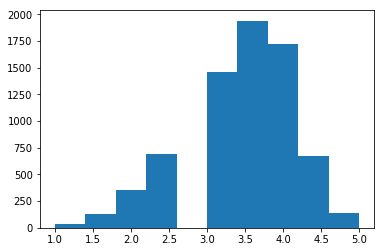

In [270]:
plt.hist(avg_rating['avg_rating'])
plt.show()                                                # need to label axes, add title, fix binning 

The horizontal axis represents the average rating values, while the vertical axis shows the number of restaurants that have those values.  For example, 1725 restaurants have an average rating of 4 stars.

Knowing the distribution of average ratings, let's define "Top Restaurants" as those having the highest average ratings.

#### Practice Exercise 2: What are the top 10 restaurants in Toronto based on average rating?

For this exercise, return the restaurant name, along with its corresponding average rating and number of reviews.  Recall from our property graph data model that a `Business` has property `num_reviews`.

In [226]:
ex2 = """
      MATCH (b:Business)-[:IN_CITY]->(c:City {name:'Toronto'}),
            (b)-[:IN_CATEGORY]->(cat:Category {name:'Restaurants'})
      RETURN b.name as name, b.avg_rating as avg_rating, b.num_reviews as num_reviews
      ORDER BY b.avg_rating DESC
      LIMIT 10
      """

with driver.session() as session:
    result_ex2 = session.run(ex2)

top_restaurants = pd.DataFrame([dict(record) for record in result_ex2])
display(top_restaurants[['name','avg_rating','num_reviews']])  

,name,avg_rating,num_reviews
0,Ontario Fresh & Tasty,5.0,4
1,Coffee Crate,5.0,3
2,Popeyes Louisiana Kitchen,5.0,3
3,Brando's Fried Chicken,5.0,3
4,Sicily Pizza,5.0,3
5,Street Feast Grill,5.0,5
6,FruiteaO,5.0,4
7,Chopsticks+Forks,5.0,3
8,Eupin Chinese Takeout,5.0,4
9,The Windmill Restaurant,5.0,3


The above query returns the top 10 restaurants based on average ratings.  Can you spot a potential issue with our definition of 'Top Restaurants'?  Although each restaurant has a perfect average rating of 5 stars, we can see that they were reviewed by at most 5 users.    

An alternative way of defining "Top Restaurants" is to combine average rating and number of reviews, placing more importance in the latter.  In addition, now that we understand the distribution of average ratings, we can further refine our definition to include only those restaurants with an average rating of at least 4 stars.  Recall from our distribution that only 25% of restaurants in Toronto have an average rating of 4 or more stars.

#### Query 5:  What are the top 10 restaurants in Toronto based on number of reviews and average rating?

In [227]:
query5 = """
         MATCH (b:Business)-[:IN_CITY]->(c:City {name:'Toronto'}),
               (b)-[:IN_CATEGORY]->(cat:Category {name:'Restaurants'})
         WHERE b.avg_rating >= 4
         RETURN b.name as name, b.avg_rating as avg_rating, b.num_reviews as num_reviews
         ORDER BY b.num_reviews DESC, b.avg_rating DESC
         LIMIT 10
         """

with driver.session() as session:
    result5 = session.run(query5)

top_reviewed_restaurants = pd.DataFrame([dict(record) for record in result5])
display(top_reviewed_restaurants[['name','avg_rating','num_reviews']])  

,name,avg_rating,num_reviews
0,Pai Northern Thai Kitchen,4.5,1494
1,Khao San Road,4.0,1270
2,KINKA IZAKAYA ORIGINAL,4.0,1184
3,Banh Mi Boys,4.0,973
4,Seven Lives Tacos Y Mariscos,4.5,945
5,Sansotei Ramen,4.0,701
6,Insomnia Restaurant & Lounge,4.0,690
7,Gusto 101,4.0,673
8,Hokkaido Ramen Santouka,4.0,651
9,The Stockyards,4.0,646


This looks more convincing! And, as a Torontonian who has been to 7 out of 10 of these restaurants, I can personally vouch for the accuracy of the list above!  ;)

Given that the top 10 restaurants above are primarily businesses with only a single location, we would like to understand how restaurants with multiple locations fit in the overall Toronto food scene.  Concretely, what are the top 10 restaurants in Toronto based on the number of different locations that they service?  Recall from our property graph data model that a business has a `name`, an `id` and an `address`.  A business can have the same name, and have two different IDs corresponding to two different addresses.

#### Query 6:  What are the top 10 restaurants in Toronto based on the number of locations they service?

In [228]:
query6 = """
         MATCH (b:Business)-[:IN_CITY]->(c:City {name:'Toronto'}),
               (b)-[:IN_CATEGORY]->(cat:Category {name:'Restaurants'})
         RETURN b.name as name, COUNT(DISTINCT(b.id)) as num_locations, 
                AVG(b.avg_rating) as avg_rating, SUM(b.num_reviews) as num_reviews
         ORDER BY num_locations DESC
         LIMIT 10
         """

with driver.session() as session:
    result6 = session.run(query6)

top_chains = pd.DataFrame([dict(record) for record in result6])
display(top_chains[['name','num_locations','avg_rating','num_reviews']])  

,name,num_locations,avg_rating,num_reviews
0,McDonald's,46,2.413043,461
1,Subway,41,2.390244,177
2,Tim Hortons,38,2.723684,248
3,Starbucks,34,3.441176,271
4,Pizza Pizza,33,2.348485,236
5,Swiss Chalet Rotisserie & Grill,32,2.562500,376
6,Pizzaiolo,25,2.860000,354
7,Freshii,23,2.913043,321
8,Popeyes Louisiana Kitchen,23,2.434783,227
9,Aroma Espresso Bar,21,3.142857,552


First, we note two Cypher functions that we have not yet seen in previous queries: `AVG<expression>` and `SUM(<expression>)`.  They are similar to their SQL counterparts, computing the field average and sum respectively.

From the output, we see that the restaurants are primarily fast-food chains.  As reflected in the average ratings, they are not necessarily highly rated, but is likely what we would expect of casual, fast-service venues.

By looking at the number of locations for a given restaurant, we were able to identify a subset of the restaurant category: fast-food chains!  Let's now look at other categories associated with restaurants and see which ones are most popular.  'Popular' in this case refers to categories with the most number of restaurants.

#### Query 7:  What are the top 10 categories associated with restaurants?

In [229]:
query7 = """
         // Section 1
         MATCH (b:Business)-[:IN_CITY]->(c:City {name:'Toronto'}),
               (b)-[:IN_CATEGORY]->(cat:Category {name:'Restaurants'})
        
         // Section 2
         WITH b.id AS restaurants
         
         // Section 3
         MATCH (r:Business)-[:IN_CATEGORY]->(c:Category)
         WHERE r.id IN [restaurants]
           AND c.name <> 'Restaurants'
           
         // Section 4
         RETURN c.name as category, COUNT(r) as num_restaurants
         ORDER BY num_restaurants DESC
         LIMIT 10
         """

with driver.session() as session:
    result7 = session.run(query7)

top_categories = pd.DataFrame([dict(record) for record in result7])
display(top_categories)

,category,num_restaurants
0,Food,1478
1,Nightlife,940
2,Bars,907
3,Canadian (New),629
4,Sandwiches,619
5,Breakfast & Brunch,606
6,Italian,566
7,Chinese,559
8,Cafes,551
9,Pizza,509


This is by far the most complex-looking query that we have seen in this module, but fear not, it's actually not that complicated! We have divided the query into 4 logical sections to help us better understand what exactly it's doing.

Section 1 simply finds all businesses in Toronto that are in category `Restaurants`. Section 2 uses the `WITH` clause to allow the query result from Section 1 to be referenced in Section 3.  In this case, we are passing restaurant IDs to Section 3.  Still with me?  

Section 3 then queries the graph again, but this time limiting the businesses to those from Section 1.  This is accomplished with the use of the `IN` statement in the `WHERE` clause.  Since we are only interested in categories associated with `Restaurants`, we choose not to display `Restaurants` as part of our result set.  This is done by adding an additional statement in the `WHERE` clause such that `c.name <> 'Restaurants'`.  

Section 4 then uses the restaurants and categories from Section 3.  It groups by category and counts the number of restaurants belonging to that category.  It then limits the result set to the top 10 categories with the most number of restaurants.  

That wasn't too bad, was it?  Now on to the output... Recall that we have a total of 7148 restaurants in Toronto.  The table above shows that of these restaurants, 1478/7148 or 21% are also tagged as being in category `Food`.  Perhaps this is not the most interesting insight, but if we look down the list, we do see variety in categories associated with restaurants in Toronto.  Of particular interest is the `Breakfast & Brunch` category as it has been a trend in Toronto for quite some time and continues to be popular.  This leads us to our final practice exercise.

#### Practice Exercise 3:  What are the top 10 neighborhoods with the most breakfast and brunch restaurants?

In [230]:
ex3 = """
      MATCH (b:Business)-[:IN_CITY]->(c:City {name:'Toronto'}),
            (b)-[:IN_CATEGORY]->(cat:Category {name:'Breakfast & Brunch'})
      WHERE b.neighborhood <> ''
      RETURN b.neighborhood as neighborhood, COUNT(b) as num_bnb
      ORDER BY num_bnb DESC
      LIMIT 10
      """

with driver.session() as session:
    result_ex3 = session.run(ex3)

top_neighborhoods_bnb = pd.DataFrame([dict(record) for record in result_ex3])
display(top_neighborhoods_bnb)

,neighborhood,num_bnb
0,Downtown Core,57
1,Leslieville,32
2,Church-Wellesley Village,21
3,Scarborough,21
4,Etobicoke,19
5,The Junction,19
6,Entertainment District,17
7,Kensington Market,17
8,Corktown,16
9,Yonge and Eglinton,14


With the Downtown Core accounting for 9% of total restaurants in Toronto, it is not surprising that it is also the top neighborhood for `Breakfast & Brunch` restaurants.  Worth noting is Leslieville, an up-and-coming neighborhood, known for the ridiculous line-ups on weekends at [Lady Marmalade](http://ladymarmalade.ca) and [Bonjour Brioche](http://www.bonjourbrioche.com/)!

This concludes the Exploratory Data Analysis module.  It's now time to showcase what you've learned!  :)

### Quiz

1: Given the following Cypher query, what value does it return? 

            MATCH (b:Business)-[:IN_CITY]->(c:City {name:'Toronto'}),                               
                  (b)-[:IN_CATEGORY]->(cat:Category {name:'Restaurants'})
            RETURN AVG(b.num_reviews) AS output

    a. average number of restaurants in Toronto  
    b. number of restaurants in Toronto  
    c. number of reviews for restaurants in Toronto    
    d. average number of reviews per restaurant in Toronto  

2: How does Cypher filter result sets?  
   
    a. by using an `ORDER BY` clause  
    b. by using graph patterns  
    c. by using a `COUNT` expression  
    d. by using a `WHERE` clause  

3: What does the following Cypher query return?

            MATCH (b:Business)-[:IN_CITY]->(c:City {name:'Toronto'}),                               
                  (b)-[:IN_CATEGORY]->(cat:Category)
            WHERE cat.name IN ['Italian','Cafes']
            RETURN cat.name, COUNT(b)

    a. count of businesses in all categories in Toronto
    b. count of Italian Cafes in Toronto
    c. count of Italian businesses and count of Cafes in Toronto 
    d. count of category names in Toronto  

4: Which of the following can be used to connect Cypher queries?

    a. RETURN 
    b. WITH  
    c. DISTINCT  
    d. HAVING

5: Will the following Cypher query execute successfully?

         MATCH (b:Business)-[:IN_CITY]->(c:City {name:'Toronto'}),
               (b)-[:IN_CATEGORY]->(cat:Category)
         WHERE b.category = 'Restaurants'
         RETURN b.name as name, COUNT(DISTINCT(b.id)) as num_locations
         HAVING num_locations > 10
         
    a. No, because the HAVING clause should be placed before the RETURN statement
    b. No, because the RETURN statement cannot have an aggregate function  
    c. Yes, because there is no problem with the query above  
    d. No, because the HAVING clause is not valid in Cypher

### TO DO:   
CHANGE DRIVER IN LOAD CSV NOTEBOOK, CREATE NOTEBOOK FOR NEO4J IMPORT, COMPARE RUN TIMES OF LOAD CSV AND NEO4J IMPORT, ADD BUSINESS ADDRESS AND LONG/LAT TO DATA MODEL AND LOAD/IMPORT